In [3]:
from IPython.display import IFrame
IFrame("./assets/OP Project requirements", width=600, height=300)

# loding the data and libraries 

In [1]:
import requests
import pandas as pd
import itertools
from heapq import heapify,heappush,heappop
import random as rd

In [2]:
data=dict()
for i in range(1,9):
    key=f'p0{i}'
    data[key]={}
    data[key]['W']=[int(num)for num in (requests.get(f'https://people.sc.fsu.edu/~jburkardt/datasets/knapsack_01/p0{i}_w.txt').text.split('\n')[:-1])]
    data[key]['V']=[int(num)for num in (requests.get(f'https://people.sc.fsu.edu/~jburkardt/datasets/knapsack_01/p0{i}_p.txt').text.split('\n')[:-1])]
    data[key]['C']= int (requests.get(f'https://people.sc.fsu.edu/~jburkardt/datasets/knapsack_01/p0{i}_c.txt').text.split('\n')[0])
    data[key]['S']=[int(num)for num in (requests.get(f'https://people.sc.fsu.edu/~jburkardt/datasets/knapsack_01/p0{i}_s.txt').text.split('\n')[:-1])]

In [3]:
data['p01']

{'W': [23, 31, 29, 44, 53, 38, 63, 85, 89, 82],
 'V': [92, 57, 49, 68, 60, 43, 67, 84, 87, 72],
 'C': 165,
 'S': [1, 1, 1, 1, 0, 1, 0, 0, 0, 0]}

# Approximate Methods

## basic greedy

In [4]:
def knapsack_greedy(W, V, C , M=1, big_first=True, on_W=True, on_V=True):
    if on_V and on_W:
        heuristic_list=[(V[i]/W[i], i) for i in range(len(W))]
    elif on_W:
       heuristic_list=[(W[i], i) for i in range(len(W))]   
    elif on_V:
        heuristic_list=[(V[i], i) for i in range(len(W))]
    
    heuristic_list.sort(key= lambda l:l[0], reverse=big_first) #sort upon v/w
    best_picked=None
    best_v=-float('inf')
    best_w=0
    for m in range(M):
        picked = [0] * len(W) # make list of zeros
        total_w=0
        total_v=0
        for i in range(m,m+len(W)):
            i%=len(W)
            item_index=heuristic_list[i][1]
            if total_w+ W[item_index]<= C:
                total_w+= W[item_index]
                total_v+= V[item_index]
                picked[item_index]=1
        
        if total_v> best_v:
            best_v=total_v
            best_bag=picked
            best_w=total_w
    return best_bag[::-1], best_v,best_w

## basic greedy with diffrent heuristics
get the best resault using diffrent heuristics

In [5]:
def knapsack_greedy_foreset(W, V, C):
    all_best=[]
    for bb,wb, vb in itertools.product([True,False],repeat=3):
        if wb==False and vb==False:
            continue
        all_best.append(knapsack_greedy(W,V,C,len(W),bb, wb, vb))
    return max(all_best, key= lambda l:l[1])

## Greedy best

### playing with binary before writing the algorithm to be sure

In [6]:
picks=132
all_picked=2**10
l=[0]*10
new=[0]*10
for i in range(10) :
    m=picks&1
    picks>>=1
    l[10-i-1]=m
print(l)
picks=132
k=picks
for i in range(10) :
    m=k&1
    k>>=1
    print(i,bin(picks))
    if m==0:
        print(bin(picks|1<<(i)))
    print(10*'-')

[0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
0 0b10000100
0b10000101
----------
1 0b10000100
0b10000110
----------
2 0b10000100
----------
3 0b10000100
0b10001100
----------
4 0b10000100
0b10010100
----------
5 0b10000100
0b10100100
----------
6 0b10000100
0b11000100
----------
7 0b10000100
----------
8 0b10000100
0b110000100
----------
9 0b10000100
0b1010000100
----------


### A star search
this give optimal solutiion (as brute force with exploring good solutions)

In [7]:
class Node:
    def __init__(self,w, v, level,heuristic,picked):
        self.level=level
        self.picked=picked
        self.w=w
        self.v=v
        self.heuristic=heuristic

    
    
    # explore all available action
    def generate_children(self, W, V, C , heuristic_list,picks,explord_set ):
        remain=picks
        for i in range(len(W)) :
            new_w=self.w+W[i]
            bit=remain&1   # pick first digit
            remain>>=2
            new_pick=picks| 1<<i
            if not bit and  new_w<=C and not(new_pick in explord_set):
              explord_set.add(new_pick)
              yield Node(new_w,self.v+V[i],self.level+1,self.heuristic+heuristic_list[i], new_pick)

        

    # To meet heapfiy requirement
    def __lt__ (self,other):
        return -self.heuristic<-other.heuristic


In [8]:

def A_star_search(W, V, C):
    W.reverse()
    V.reverse()
    heuristic_list=[ V[i]/W[i] for i in range(len(W))]
    root=Node(0,0,0,0,0)
    queue=[(-root.heuristic, root)] # the negitave hueuristic is the Priority (-hue, refrance to state)
    heapify(queue) 
    best_Node=None
    best_v=-float('inf')
    explord=set()
    while len(queue) !=0: # while queue is not empty
        currunt=heappop(queue) 
        for child in currunt[1].generate_children( W, V, C ,heuristic_list, currunt[1].picked, explord):
                if child.heuristic > currunt[1].heuristic:
                    heappush(queue,(-child.heuristic, child))

        
        if best_v< currunt[1].v:
             best_Node=currunt[1]
             best_v=best_Node.v
    #return binary to list
    picks=best_Node.picked
    best_picked=[0]*len(W)
    for i in reversed(range(len(W))) :
        m=picks&1
        picks>>=1
        best_picked[i]=m
    return best_picked, best_Node.v, best_Node.w

### 1.3.2 Greedy best(not sure about the name)
this is similar to A star with adding best_n options

In [16]:
class Node2:
    def __init__(self,w, v, level,heuristic,picked, action):
        self.level=level
        self.picked=picked
        self.w=w
        self.v=v
        self.heuristic=heuristic
        self.action=action

    
    
    # explore best_n available action
    def generate_children(self, W, V, C , heuristic_list,explord_set,best_n:int):
        children=[]

        if self.action is None:
            for i in range(best_n):
                item_index=heuristic_list[i][1]
                new_pick=self.picked| 1<<item_index
                children.append(Node2(self.w+W[item_index],self.v+V[item_index],self.level+1,self.heuristic+heuristic_list[i][0],new_pick,i))
        else:
            for i in range(self.action+1, self.action+best_n+1):
                i%=len(heuristic_list)
                item_index=heuristic_list[i][1]
                new_pick=self.picked| 1<<item_index
                new_w=self.w+W[item_index]
                if(new_w<=C and  not new_pick in explord_set):
                    children.append(Node2(new_w,self.v+V[item_index],self.level+1,self.heuristic+heuristic_list[i][0],new_pick,i))
                    explord_set.add(new_pick)
        return children

    # To meet heapfiy requirement
    def __lt__ (self,other):
        return -self.heuristic<-other.heuristic

In [17]:
def greedy_best_search(W, V, C, best_n:int=4):
    heuristic_list=[ (V[i]/W[i],i) for i in range(len(W))]
    heuristic_list.sort(reverse=True)
    root=Node2(0,0,0,0,0,None)
    queue=[(-root.heuristic, root)] # the negitave hueuristic is the Priority (-hue, refrance to state)
    heapify(queue) 
    best_Node=None
    best_v=-float('inf')
    explord=set()
    while len(queue) !=0: # while queue is not empty
        currunt=heappop(queue) 
        for child in currunt[1].generate_children( W, V, C ,heuristic_list,explord, best_n):
                if child.heuristic > currunt[1].heuristic:
                    heappush(queue,(-child.heuristic, child))

        
        if best_v< currunt[1].v:
             best_Node=currunt[1]
             best_v=best_Node.v
    
    #turn binary to list
    picks=best_Node.picked
    best_picked=[0]*len(W)
    for i in reversed(range(len(W))) :
        m=picks&1
        picks>>=1
        best_picked[i]=m
    return best_picked, best_Node.v, best_Node.w

# Exact Method

##  Brute Force
give you all optimal solutions 

In [12]:
def knapsack_brute_force(W, V, C):
    N = len(W)
    max_value = 0
    best_picked = []
    
    for i in range(1, N + 1):
        combinations = itertools.combinations(range(N), i)
        for combination in combinations:
            picked = [0] * N # make list of zeros
            weight = 0
            value = 0
            for j in combination:
                picked[j] = 1
                weight += W[j]
                value += V[j]
            if weight <= C and value == max_value:
                best_picked.append(picked)
            if weight <= C and value > max_value:
                max_value = value
                best_picked = [ picked ]
    
    return best_picked, max_value, sum([W[i] for i in range(N) if best_picked[0][i] == 1])

## Dynamic programming

In [13]:
def knapsack_dynamic_programming(W, V, C):
    T=[[0]*(C+1) for _ in range(len(W)+1)] # lists of zeros (C+1) x (W+1)

    for i in range(1,len(W)+1):
      for c in range(1,C+1):
        T[i][c]=max(T[i-1][c], T[i-1][c-W[i-1]]+V[i-1]) if (W[i-1]<=c) else T[i-1][c]
    
    # backtracking
    best_picked=[0]*len(W)
    total_weight=0
    current_value=T[len(W)][C]
    current_C=C 
    for i in reversed(range(len(W))):
      if current_value!= T[i][current_C]:
        best_picked[i]=1
        current_value-=V[i]
        total_weight+=W[i]
        current_C-=W[i]

    return best_picked,T[len(W)][C], total_weight

In [14]:
w = ( 8672, 33819, 15522, 18766, 6981, 36714, 28014, 33108, 36091, 3014 )
v = ( 85243, 44610, 67702, 66560, 74515, 14032, 41000, 55416, 83574, 74870 )
picked, total_value, total_weight = knapsack_dynamic_programming(w, v, 89654)
print("Items picked:", picked)
print("Total value:", total_value)
print("Total weight:", total_weight)

Items picked: [1, 0, 1, 1, 1, 0, 0, 0, 1, 1]
Total value: 452464
Total weight: 89046


# Performence

In [10]:
# Example usage
C = 10000
W = [rd.randint(1,1000) for _ in range(23)]
V = [ rd.randint(1,1000) for _ in range(23)]

## comparing running time 
This is not accurate.  we have to try different inputs but this just to get insghit

In [33]:
%%timeit
picked, total_value, total_weight = knapsack_greedy_foreset(W, V, C)

402 µs ± 5.09 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [18]:
%%timeit
picked, total_value, total_weight = greedy_best_search(W, V, C)

7.15 s ± 31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%%timeit
picked, total_value, total_weight = A_star_search(W, V, C)

35.8 s ± 594 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit
picked, total_value, total_weight = knapsack_brute_force(W, V, C)

5.98 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%%timeit
picked, total_value, total_weight = knapsack_dynamic_programming(W, V, C)

46.7 ms ± 221 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Example Usage

In [21]:
picked, total_value, total_weight = knapsack_brute_force(W, V, C)
print("Items picked:", picked)
print("Total value:", total_value)
print("Total weight:", total_weight)

Items picked: [[1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]]
Total value: 12297
Total weight: 9662


In [22]:
picked, total_value, total_weight = knapsack_dynamic_programming(W, V, C)
print("Items picked:", picked)
print("Total value:", total_value)
print("Total weight:", total_weight)

Items picked: [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
Total value: 12297
Total weight: 9662


In [11]:
picked, total_value, total_weight = A_star_search(W, V, C)
print("Items picked:", picked)
print("Total value:", total_value)
print("Total weight:", total_weight)

Items picked: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0]
Total value: 10631
Total weight: 9868


In [12]:
picked, total_value, total_weight = knapsack_greedy_foreset(W, V, C)
print("Items picked:", picked)
print("Total value:", total_value)
print("Total weight:", total_weight)

Items picked: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0]
Total value: 10631
Total weight: 9868


In [25]:
picked, total_value, total_weight = greedy_best_search(W, V, C)
print("Items picked:", picked)
print("Total value:", total_value)
print("Total weight:", total_weight)

Items picked: [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
Total value: 12297
Total weight: 9662


# Instances and Comparison

In [35]:
benchmark={}
for ex, ex_data in data.items():
    benchmark['C']=benchmark.get('C',())+(ex_data['C'],)
    benchmark['W_len']=benchmark.get('W_len', ())+(len(ex_data['W']),)
    _ , total_value, total_weight = knapsack_greedy_foreset(ex_data['W'], ex_data['V'],ex_data['C'])
    benchmark['Greedy F Value']=benchmark.get('Greedy F Value',())+(total_value,)
    benchmark['Greedy F Weight']=benchmark.get('Greedy F Weight',())+(total_weight,) 
    _ , total_value, total_weight = greedy_best_search(ex_data['W'], ex_data['V'],ex_data['C'])
    benchmark['Greedy B Value']=benchmark.get('Greedy B Value',())+(total_value,)
    benchmark['Greedy B Weight']=benchmark.get('Greedy B Weight',())+(total_weight,) 
    _ , total_value, total_weight = knapsack_brute_force(ex_data['W'], ex_data['V'],ex_data['C'])
    benchmark['OPT Value']=benchmark.get('OPT Value',())+(total_value,)
    benchmark['OPT Weight']=benchmark.get('OPT Weight',())+(total_weight,) 

In [36]:
bench_df=pd.DataFrame(benchmark, index=data.keys())

In [37]:
bench_df['Greedy B/OPT']=bench_df['Greedy B Value']/bench_df['OPT Value']
bench_df['Greedy F/OPT']=bench_df['Greedy F Value']/bench_df['OPT Value']

In [38]:
bench_df

,C,W_len,Greedy F Value,Greedy F Weight,Greedy B Value,Greedy B Weight,OPT Value,OPT Weight,Greedy B/OPT,Greedy F/OPT
p01,165,10,309,165,309,165,309,165,1.0,1.000000
p02,26,5,51,26,51,26,51,26,1.0,1.000000
p03,190,6,150,190,150,190,150,190,1.0,1.000000
p04,50,7,107,50,107,50,107,50,1.0,1.000000
p05,104,8,900,104,900,104,900,104,1.0,1.000000
p06,170,7,1735,169,1735,169,1735,169,1.0,1.000000
p07,750,15,1452,747,1458,749,1458,749,1.0,0.995885
p08,6404180,24,13415886,6323699,13549094,6402560,13549094,6402560,1.0,0.990168


<Axes: >

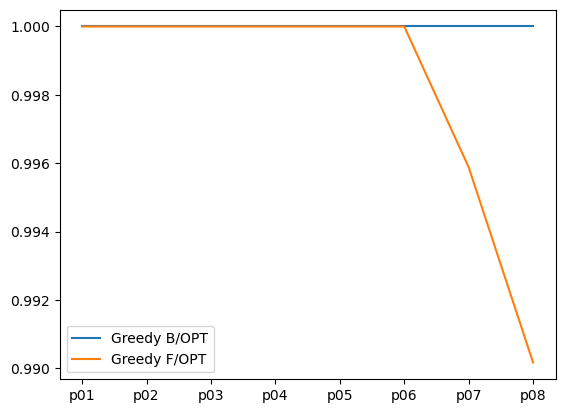

In [39]:
bench_df.loc[:,['Greedy B/OPT','Greedy F/OPT']].plot()

In [31]:
sum([data['p01']['V'][i]for i,p in enumerate(data['p01']['S']) if p ])

309

# Conclusion

Each algorithm has its strengths and weakneass. For instance, basic greedy is very efficient and give very good resualts. However, when we have so many items and low capacity. dynamic programming is efficient and optimal. On the other hand, if we have high capacity and few items then brute force is a good one. Greedy best and A_star are efficient and optimal(with the right n_best for greedy) if the item wights are big compared to the capacity. 